In [332]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [333]:
# collector_df = pd.read_csv('../data/qos/reports.csv')
# sender_df = pd.read_csv('../data/qos/latency_udp.csv')
# t = (200, 260)

# collector_df = pd.read_csv('../data/increasing/reports.csv')
# sender_df = pd.read_csv('../data/increasing/latency_udp.csv')
# t = (400, 450)

# collector_df = pd.read_csv('../data/constant/reports.csv')
# sender_df = pd.read_csv('../data/constant/latency_udp.csv')
# t = (400, 450)

# collector_df = pd.read_csv('../data/http/reports.csv')
# sender_df = pd.read_csv('../data/http/latency_http.csv')
# t = (1860, 1905)


collector_df = pd.read_csv('../data/http2/reports.csv')
sender_df = pd.read_csv('../data/http2/latency_http.csv')
t = (165, 180)


sender_df.columns = ['timestamp', 'latency', 'dropped']

sender_df['latency'] = sender_df['latency'].apply(lambda x: int(x * 1000))
collector_df['hop_latency'] = collector_df['hop_latency'].apply(lambda x: int(x / 1000))

sender_start = sender_df.iloc[0]['timestamp']
collector_start = collector_df.iloc[0]['collector_timestamp']
start = min(sender_start, collector_start)

collector_df['collector_timestamp'] -= start
sender_df['timestamp'] -= start

In [334]:
collector_df.head()

,collector_timestamp,flow_id,collection_id,src_ip,dst_ip,src_port,dst_port,protocol,seq_num,reporting_sw,...,egress_timestamp,hop_latency,ingress_timestamp,l1_egress_port_id,l1_ingress_port_id,l2_egress_port_id,l2_ingress_port_id,queue_occupancy,queue_occupancy_id,switch_id
0,0.042549,0,0,10.244.8.3,10.244.9.3,8000,53120,6,0,0,...,1715549754788794000,0,1715549754788102000,1,2,0,0,0,0,6
1,0.042549,0,0,10.244.8.3,10.244.9.3,8000,53120,6,0,0,...,1715549754790075000,0,1715549754789626000,1,2,0,0,0,0,0
2,0.042549,0,0,10.244.8.3,10.244.9.3,8000,53120,6,0,0,...,1715549754791380000,0,1715549754790947000,1,2,0,0,0,0,0
3,0.042549,0,0,10.244.8.3,10.244.9.3,8000,53120,6,0,0,...,1715549754791751000,0,1715549754791632000,1,3,0,0,0,0,1
4,0.042549,0,0,10.244.8.3,10.244.9.3,8000,53120,6,0,0,...,1715549754811826000,20,1715549754791751000,1,0,0,0,1,0,0


In [335]:
sender_df.head()

,timestamp,latency,dropped
0,0.000000,157,0
1,0.220493,220,0
2,0.453670,233,0
3,0.692429,238,0
4,0.931846,239,0


<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

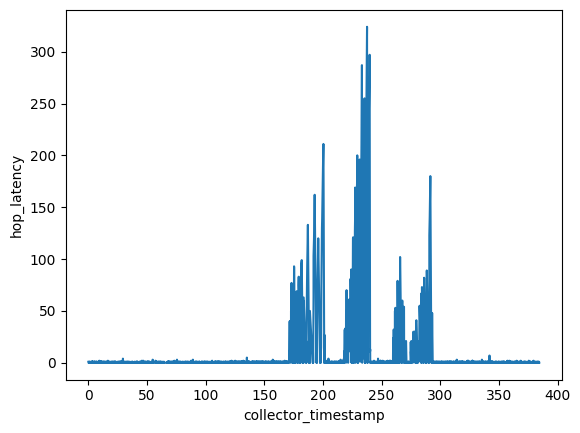

In [336]:
sns.lineplot(data=collector_df[(collector_df['switch_id']==1) & (collector_df['l1_egress_port_id']==3)], x='collector_timestamp', y='hop_latency')

<Axes: xlabel='collector_timestamp', ylabel='queue_occupancy'>

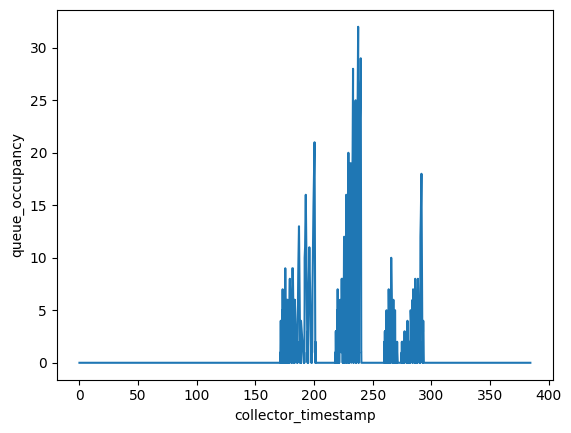

In [337]:
sns.lineplot(data=collector_df[(collector_df['switch_id']==1) & (collector_df['l1_egress_port_id']==3)], x='collector_timestamp', y='queue_occupancy')

<Axes: xlabel='timestamp', ylabel='latency'>

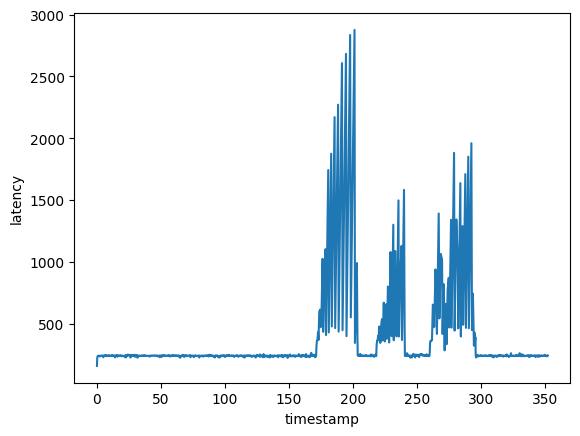

In [338]:
sns.lineplot(data=sender_df, x='timestamp', y='latency')

In [339]:
collector_df

,collector_timestamp,flow_id,collection_id,src_ip,dst_ip,src_port,dst_port,protocol,seq_num,reporting_sw,...,egress_timestamp,hop_latency,ingress_timestamp,l1_egress_port_id,l1_ingress_port_id,l2_egress_port_id,l2_ingress_port_id,queue_occupancy,queue_occupancy_id,switch_id
0,0.042549,0,0,10.244.8.3,10.244.9.3,8000,53120,6,0,0,...,1715549754788794000,0,1715549754788102000,1,2,0,0,0,0,6
1,0.042549,0,0,10.244.8.3,10.244.9.3,8000,53120,6,0,0,...,1715549754790075000,0,1715549754789626000,1,2,0,0,0,0,0
2,0.042549,0,0,10.244.8.3,10.244.9.3,8000,53120,6,0,0,...,1715549754791380000,0,1715549754790947000,1,2,0,0,0,0,0
3,0.042549,0,0,10.244.8.3,10.244.9.3,8000,53120,6,0,0,...,1715549754791751000,0,1715549754791632000,1,3,0,0,0,0,1
4,0.042549,0,0,10.244.8.3,10.244.9.3,8000,53120,6,0,0,...,1715549754811826000,20,1715549754791751000,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95119,384.430554,19023,0,10.244.9.3,10.244.8.3,36402,8000,6,5711,6,...,1715550139197126000,0,1715550139196315000,1,0,0,0,0,0,6
95120,384.443810,19024,0,10.244.8.3,10.244.9.3,8000,36402,6,8170,0,...,1715550139207136000,9,1715550139197559000,1,2,0,0,0,0,6
95121,384.443810,19024,0,10.244.8.3,10.244.9.3,8000,36402,6,8170,0,...,1715550139209128000,1,1715550139207563000,1,2,0,0,0,0,0
95122,384.443810,19024,0,10.244.8.3,10.244.9.3,8000,36402,6,8170,0,...,1715550139210071000,0,1715550139209636000,1,2,0,0,0,0,0


In [340]:
collector_df['port_key'] = collector_df.apply(lambda row: f'{row["switch_id"]}_{row["l1_egress_port_id"]}', axis=1)

In [341]:
collector_df['port_key'].unique()

array(['6_1', '0_1', '1_1', '1_3', '0_2', '0_3', '5_2', '8_1', '5_1'],
      dtype=object)

<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

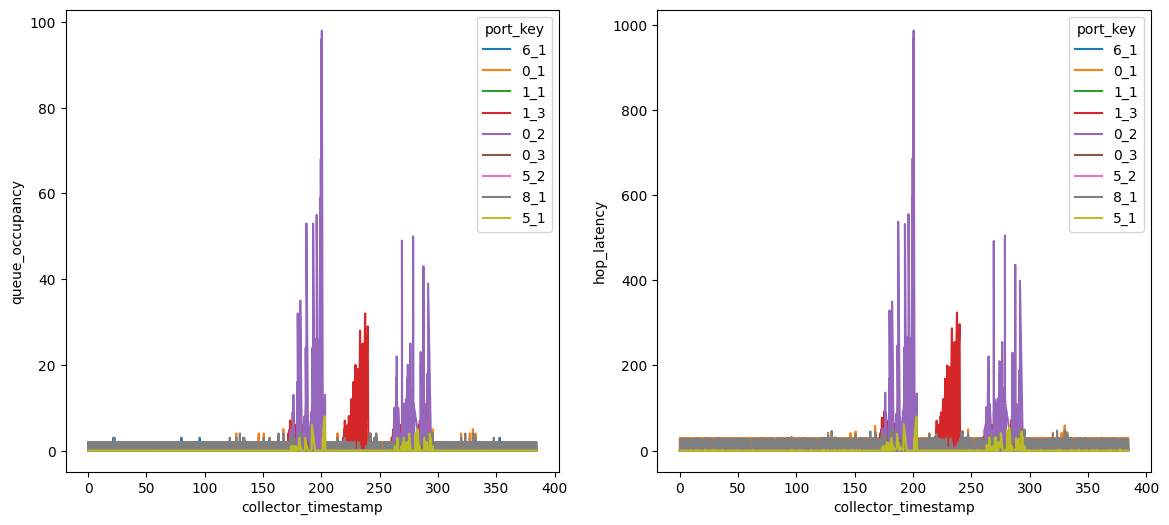

In [342]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.lineplot(ax=ax[0], data=collector_df, x='collector_timestamp', y='queue_occupancy', hue='port_key', legend=True, estimator=None, n_boot=0)
sns.lineplot(ax=ax[1], data=collector_df, x='collector_timestamp', y='hop_latency', hue='port_key', legend=True, estimator=None, n_boot=0)

<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

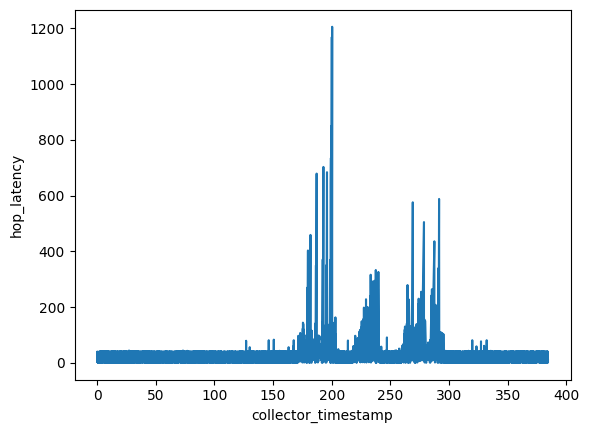

In [343]:
grouped_df = collector_df.groupby(by='flow_id').agg({'hop_latency': 'sum', 'collector_timestamp': 'first'})
sns.lineplot(data=grouped_df, x='collector_timestamp', y='hop_latency')


<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

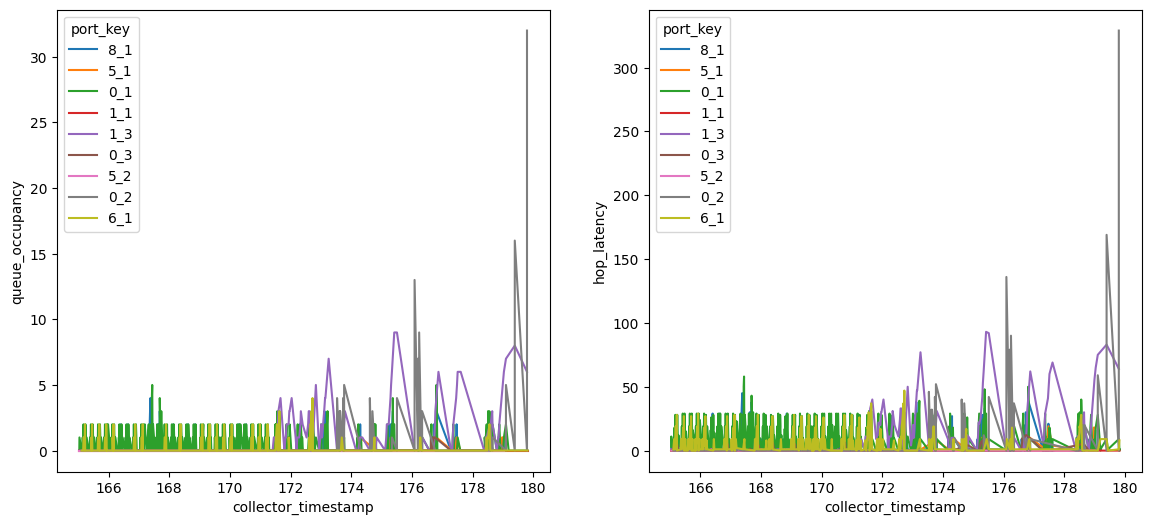

In [344]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
N = len(collector_df)
sns.lineplot(ax=ax[0], data=collector_df[(collector_df['collector_timestamp'] > t[0]) & (collector_df['collector_timestamp'] < t[1])], x='collector_timestamp', y='queue_occupancy', hue='port_key', legend=True, estimator=None, n_boot=0)
sns.lineplot(ax=ax[1], data=collector_df[(collector_df['collector_timestamp'] > t[0]) & (collector_df['collector_timestamp'] < t[1])], x='collector_timestamp', y='hop_latency', hue='port_key', legend=True, estimator=None, n_boot=0)

<Axes: xlabel='timestamp', ylabel='latency'>

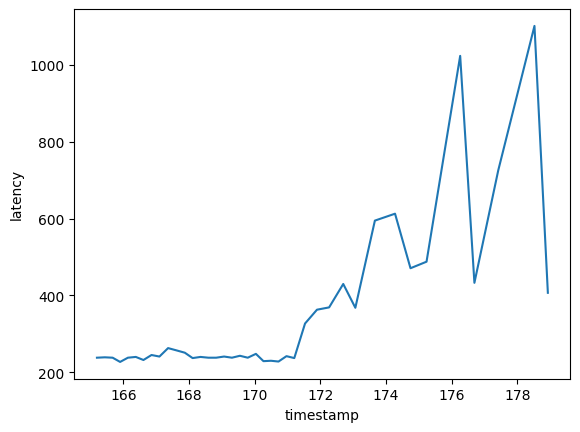

In [345]:
sns.lineplot(data=sender_df[(sender_df['timestamp'] > t[0]) & (sender_df['timestamp'] < t[1])], x='timestamp', y='latency')

<Axes: xlabel='timestamp', ylabel='dropped'>

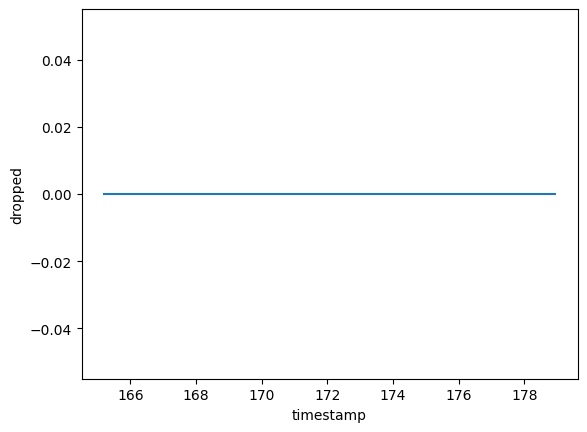

In [346]:
sns.lineplot(data=sender_df[(sender_df['timestamp'] > t[0]) & (sender_df['timestamp'] < t[1])], x='timestamp', y='dropped')

In [347]:
cols = ['timestamp', 'averagePathLatency', 'onePercentileSlowestPathLatency', 'port_key', 'averageLatency',
        'onePercentileSlowestLatency', 'onePercentileLargestQueueFillState', 'averageQueueFillState', 'packets']
rows = []
import json
max_i = 2220
for i in range(max_i+1):
    with open(f'./../data/http2/logs{i}.json', 'r') as f:
        data = json.load(f)
        base_row = [
            data['createdAt'] - start,
            data['windowMetrics']['averagePathLatencyMicroS'] / 1000,
            data['windowMetrics']['onePercentileSlowestPathLatencyMicroS'] / 1000,
        ]
        for dm in data['windowMetrics']['deviceMetrics']:
            for pm in dm['portMetrics']:
                row = [*base_row]
                port_key = f'{dm["deviceName"]}_{pm["toDevice"]}'
                row.extend([
                    port_key,
                    pm['averageLatencyMicroS'] / 1000,
                    pm['onePercentileSlowestLatencyMicroS'] / 1000,
                    pm['onePercentileLargestQueueFillState'],
                    pm['averageQueueFillState'],
                    pm['packets'],
                ])
                rows.append(row)

summary_df = pd.DataFrame.from_records(rows, columns=cols)
summary_df.head()

,timestamp,averagePathLatency,onePercentileSlowestPathLatency,port_key,averageLatency,onePercentileSlowestLatency,onePercentileLargestQueueFillState,averageQueueFillState,packets
0,120.228331,22.746,44.385,r1_r7,8.259,29.626,2,0,2142
1,120.228331,22.746,44.385,r1_tree-worker11,0.448,0.867,0,0,1024
2,120.228331,22.746,44.385,r1_tree-worker12,0.809,7.131,0,0,492
3,120.228331,22.746,44.385,r7_r1,0.475,1.195,0,0,754
4,120.228331,22.746,44.385,r7_r10,0.747,1.552,0,0,1004


In [348]:
# t=(170, 230)

<Axes: xlabel='timestamp', ylabel='onePercentileSlowestPathLatency'>

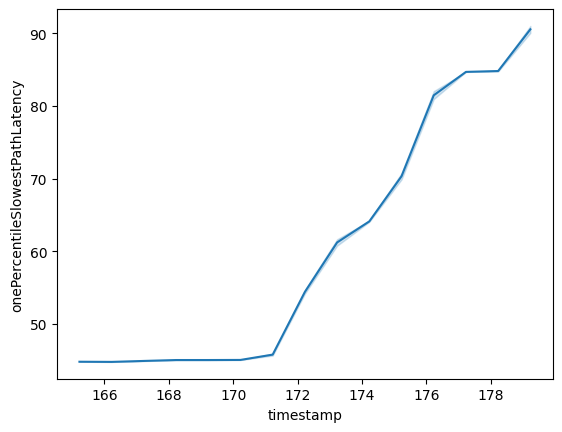

In [349]:
sns.lineplot(data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1])], x='timestamp', y='onePercentileSlowestPathLatency')

<Axes: xlabel='timestamp', ylabel='latency'>

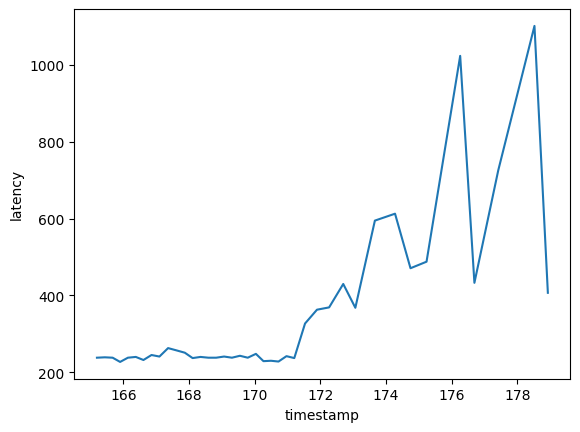

In [350]:
sns.lineplot(data=sender_df[(sender_df['timestamp'] > t[0]) & (sender_df['timestamp'] < t[1])], x='timestamp', y='latency')

<Axes: xlabel='timestamp', ylabel='averageLatency'>

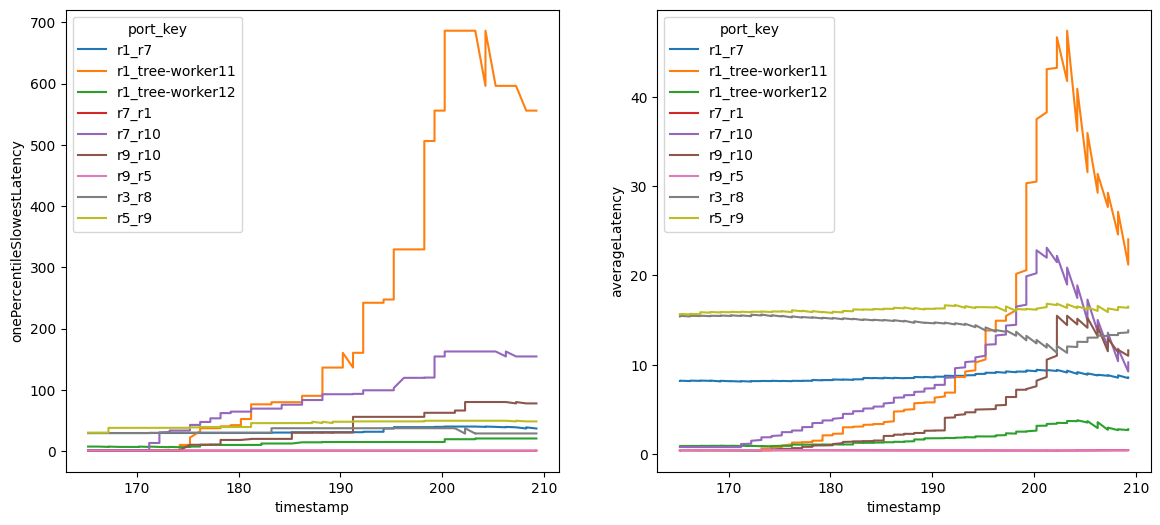

In [353]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
N = len(collector_df)
sns.lineplot(ax=ax[0], data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1] + 30)], x='timestamp', y='onePercentileSlowestLatency', hue='port_key', legend=True, estimator=None, n_boot=0)
sns.lineplot(ax=ax[1], data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1] + 30)], x='timestamp', y='averageLatency', hue='port_key', legend=True, estimator=None, n_boot=0)

<Axes: xlabel='timestamp', ylabel='averageQueueFillState'>

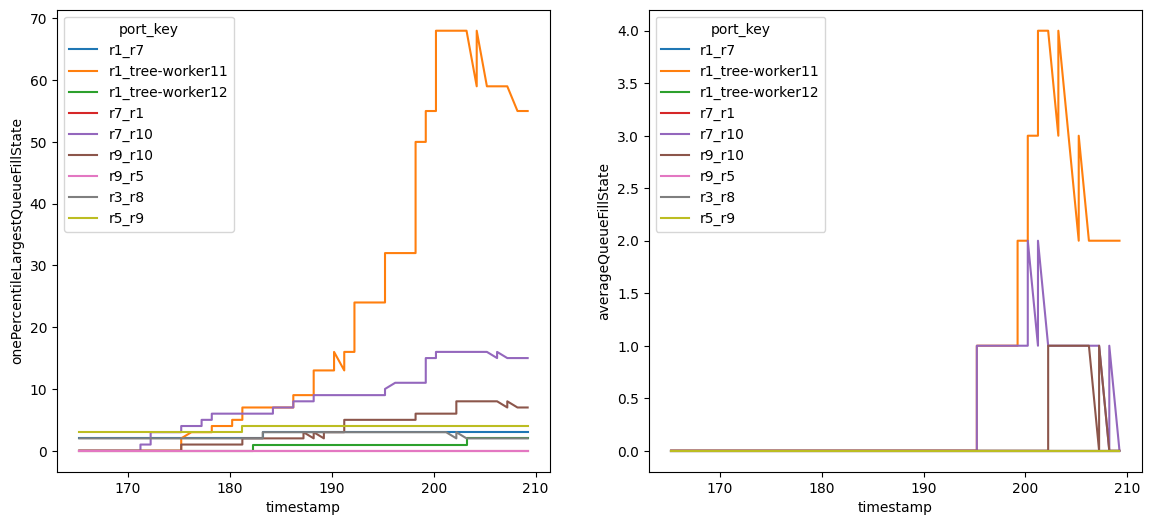

In [354]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
N = len(collector_df)
sns.lineplot(ax=ax[0], data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1] + 30)], x='timestamp', y='onePercentileLargestQueueFillState', hue='port_key', legend=True, estimator=None, n_boot=0)
sns.lineplot(ax=ax[1], data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1] + 30)], x='timestamp', y='averageQueueFillState', hue='port_key', legend=True, estimator=None, n_boot=0)